# Data Modeling

## Gradient Boosting Regressor
- We'll use the model ```GradientBoostingRegressor``` from `sklearn`.
- **Advantages of this model**
    - **Flexible to outliers**: As the model performs gradient boosting, through each iteration outliers will have less impact.
    - **Works well for small sized data**: Unlike other deep learning models that utilize gradients, Gradient Boosting Regressor can be effective even with a small dataset.

### Import libraries

In [213]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocessing

In [214]:
#Read data
df = pd.read_csv('../../data/processed/data.csv')
df.head()

,name,genre,tomatometer_score,tomatometer_count,audience_score,audience_count,classification,runtime,release_year,original_language
0,A Castle for Christmas,Holiday,0.74,23.0,0.40,100.0,Not Rated,98.0,2021,English
1,Pinocchio,Kids & family,1.00,61.0,0.73,250000.0,G,87.0,1940,English
2,The Informer,Mystery & thriller,0.64,58.0,0.60,250.0,R,113.0,2019,English
3,They Cloned Tyrone,Sci-fi,0.95,129.0,1.00,25.0,R,122.0,2023,English
4,1917,War,0.89,472.0,0.88,25000.0,R,119.0,2019,English


In [215]:
#Choose numeric features
df = df.select_dtypes('number')
#Fill na values with mean
df = df.fillna(df.mean())

### Train, Validation, Test set splitting

- We'll perform splitting on the following ratio (70/20/10)

In [216]:
train, validation, test = np.split(df.sample(frac=1, random_state=30), [int(0.7*len(df)), int(0.9*len(df))]) #70/20/10

### Hyperparameter tuning
- We'll perform hyperparameter tuning on two hyperparameters: `learning_rate` and `n_estimator`.
- We'll record the `mean_squared_error` of every combination of these parameters on the validation set.
- Finally, we'll plot the corresponding heatmap.

In [217]:
from itertools import product

learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
n_estimators = [50, 75, 100, 125, 150]

results = np.zeros((5,5))
for rate, n in product(learning_rates, n_estimators):
    #Initalize model and perform fitting
    model = GradientBoostingRegressor(loss='squared_error', learning_rate=rate, n_estimators=n)
    model.fit(train.drop('audience_score', axis=1), train['audience_score'])
    #Testing on validation set and record error
    val_predictions = model.predict(validation.drop('audience_score', axis=1))
    error = mean_squared_error(validation['audience_score'], val_predictions)
    results[learning_rates.index(rate)][n_estimators.index(n)] = error


Plotting the heatmap

Text(0.5, 1.0, 'Error matrix of model on different learning_rate and n_estimators')

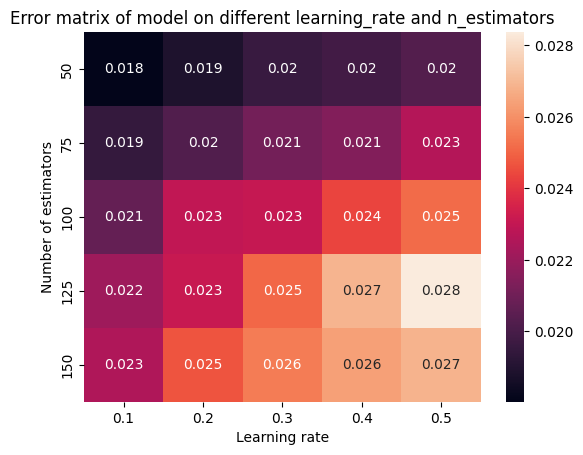

In [218]:
sns.heatmap(results, xticklabels=learning_rates, yticklabels=n_estimators, annot=True)
plt.xlabel('Learning rate')
plt.ylabel('Number of estimators')
plt.title('Error matrix of model on different learning_rate and n_estimators')

So, the best hyperparameters are `learning_rate = 0.1` and `n_estimators = 50`.

### Training and Testing/Evaluation
- We perform fitting on training + validation set.
- Use squared error as the loss function.

Training

In [219]:
best_lr = 0.1
best_n = 50

train_validation = pd.concat([train, validation])
gradient_boost = GradientBoostingRegressor(loss='squared_error', learning_rate=best_lr, n_estimators=best_n)
gradient_boost.fit(train_validation.drop('audience_score', axis=1), train_validation['audience_score'])

GradientBoostingRegressor(n_estimators=50)

Visualizing the running process

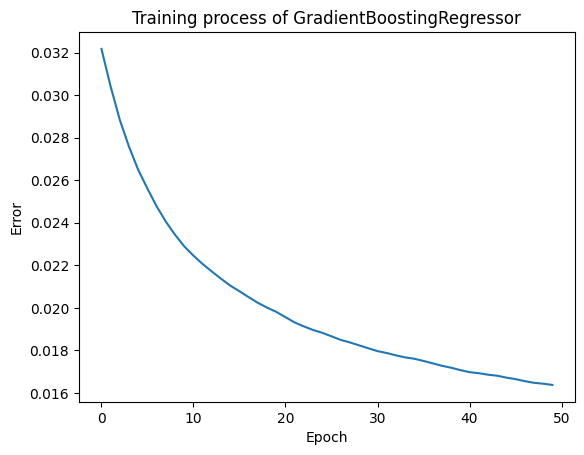

In [220]:
gradient_boost_scores = gradient_boost.train_score_
plt.plot(gradient_boost_scores)
plt.title('Training process of GradientBoostingRegressor')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

Testing

In [221]:
predictions = gradient_boost.predict(test.drop('audience_score', axis=1))
gb_error = mean_squared_error(test['audience_score'], predictions)
print("MSE:", gb_error)

MSE: 0.020113672002837927
